# MOQ Price Analysis for Wholesale B2B Businesses

## importing libraries

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [24]:
!git clone https://github.com/Ali-Zabiiihian/moq-price-analysis.git

Cloning into 'moq-price-analysis'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 71 (delta 32), reused 36 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 38.41 MiB | 5.37 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (9/9), done.


In [25]:
%cd moq-price-analysis

/content/moq-price-analysis/moq-price-analysis


## extracting the dataset

In [26]:
df = pd.read_csv('online_retail_II.csv')
print(df.dtypes)

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object


## analysing data quality

In [27]:
# finding missing data
missing_data = pd.DataFrame({
    'columns': df.columns,
    'null count': df.isnull().sum(),
    'null percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

print(missing_data)

                 columns  null count  null percentage
Invoice          Invoice           0             0.00
StockCode      StockCode           0             0.00
Description  Description        4382             0.41
Quantity        Quantity           0             0.00
InvoiceDate  InvoiceDate           0             0.00
Price              Price           0             0.00
Customer ID  Customer ID      243007            22.77
Country          Country           0             0.00


In [28]:
# finding unique data
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

Invoice: 53628
StockCode: 5305
Description: 5698
Quantity: 1057
InvoiceDate: 47635
Price: 2807
Customer ID: 5942
Country: 43


In [29]:
# getting a sample of the dataset
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [30]:
# descriptive statistics from the dataset
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


## identifying and documenting problems

In [31]:
# negative numbers in quantity
negative_qty = df[df['Quantity'] < 0]
print(negative_qty.head(10))

     Invoice StockCode                        Description  Quantity  \
178  C489449     22087           PAPER BUNTING WHITE LACE       -12   
179  C489449    85206A       CREAM FELT EASTER EGG BASKET        -6   
180  C489449     21895      POTTING SHED SOW 'N' GROW SET        -4   
181  C489449     21896                 POTTING SHED TWINE        -6   
182  C489449     22083         PAPER CHAIN KIT RETRO SPOT       -12   
183  C489449     21871                SAVE THE PLANET MUG       -12   
184  C489449     84946    ANTIQUE SILVER TEA GLASS ETCHED       -12   
185  C489449    84970S  HANGING HEART ZINC T-LIGHT HOLDER       -24   
186  C489449     22090          PAPER BUNTING RETRO SPOTS       -12   
196  C489459    90200A         PURPLE SWEETHEART BRACELET        -3   

             InvoiceDate  Price  Customer ID         Country  
178  2009-12-01 10:33:00   2.95      16321.0       Australia  
179  2009-12-01 10:33:00   1.65      16321.0       Australia  
180  2009-12-01 10:33:00   4.

In [32]:
# zero or negative prices in price
zero_price = df[df['Price'] <= 0]
print(zero_price.head(10))

     Invoice StockCode   Description  Quantity          InvoiceDate  Price  \
263   489464     21733  85123a mixed       -96  2009-12-01 10:52:00    0.0   
283   489463     71477         short      -240  2009-12-01 10:52:00    0.0   
284   489467    85123A   21733 mixed      -192  2009-12-01 10:53:00    0.0   
470   489521     21646           NaN       -50  2009-12-01 11:44:00    0.0   
3114  489655     20683           NaN       -44  2009-12-01 17:26:00    0.0   
3161  489659     21350           NaN       230  2009-12-01 17:39:00    0.0   
3162  489660     35956          lost     -1043  2009-12-01 17:43:00    0.0   
3168  489663    35605A       damages      -117  2009-12-01 18:02:00    0.0   
3731  489781     84292           NaN        17  2009-12-02 11:45:00    0.0   
4296  489806     18010           NaN      -770  2009-12-02 12:42:00    0.0   

      Customer ID         Country  
263           NaN  United Kingdom  
283           NaN  United Kingdom  
284           NaN  United Kingdom

In [33]:
# special codes (non-products)
special_codes = df[df['StockCode'].str.contains('^[A-Z]+$', na=False, regex=True)]
print(special_codes['StockCode'].value_counts().head(10))

StockCode
POST         2122
DOT          1446
M            1421
D             177
S             104
ADJUST         67
AMAZONFEE      43
DCGSSGIRL      25
DCGSSBOY       23
PADS           19
Name: count, dtype: int64


In [34]:
# missing customer id
no_customer = df[df['Customer ID'].isnull()]
print(no_customer.head(10))

     Invoice StockCode                   Description  Quantity  \
263   489464     21733                  85123a mixed       -96   
283   489463     71477                         short      -240   
284   489467    85123A                   21733 mixed      -192   
470   489521     21646                           NaN       -50   
577   489525    85226C     BLUE PULL BACK RACING CAR         1   
578   489525     85227   SET/6 3D KIT CARDS FOR KIDS         1   
1055  489548     22271          FELTCRAFT DOLL ROSIE         1   
1056  489548     22254          FELT TOADSTOOL LARGE        12   
1057  489548     22273          FELTCRAFT DOLL MOLLY         3   
1058  489548     22195  LARGE HEART MEASURING SPOONS         1   

              InvoiceDate  Price  Customer ID         Country  
263   2009-12-01 10:52:00   0.00          NaN  United Kingdom  
283   2009-12-01 10:52:00   0.00          NaN  United Kingdom  
284   2009-12-01 10:53:00   0.00          NaN  United Kingdom  
470   2009-12-01 

In [35]:
# missing descriptions
no_desc = df[df['Description'].isnull()]
print(no_desc.head(10))

     Invoice StockCode Description  Quantity          InvoiceDate  Price  \
470   489521     21646         NaN       -50  2009-12-01 11:44:00    0.0   
3114  489655     20683         NaN       -44  2009-12-01 17:26:00    0.0   
3161  489659     21350         NaN       230  2009-12-01 17:39:00    0.0   
3731  489781     84292         NaN        17  2009-12-02 11:45:00    0.0   
4296  489806     18010         NaN      -770  2009-12-02 12:42:00    0.0   
4566  489821    85049G         NaN      -240  2009-12-02 13:25:00    0.0   
6378  489882    35751C         NaN        12  2009-12-02 16:22:00    0.0   
6555  489898    79323G         NaN       954  2009-12-03 09:40:00    0.0   
6576  489901     21098         NaN      -200  2009-12-03 09:47:00    0.0   
6581  489903     21166         NaN        48  2009-12-03 09:57:00    0.0   

      Customer ID         Country  
470           NaN  United Kingdom  
3114          NaN  United Kingdom  
3161          NaN  United Kingdom  
3731          NaN  

In [36]:
# finding outliers in quantity
print(f"minimun quantity: {df['Quantity'].min()}")
print(f"maximun quantity: {df['Quantity'].max()}")
print(f"mean quantity: {df['Quantity'].mean()}")
print(f"99 percentile quantity: {df['Quantity'].quantile(0.99)}")
print(f"99.9 percentile quantity: {df['Quantity'].quantile(0.999)}")

minimun quantity: -80995
maximun quantity: 80995
mean quantity: 9.9388984711033
99 percentile quantity: 100.0
99.9 percentile quantity: 500.0


## cleaning the dataset

In [37]:
# getting a copy for the process
df_clean = df.copy()
print(f"number of initial records: {len(df_clean)}")

number of initial records: 1067371


In [38]:
# cleaning report
cleaning_report = {
    'step': [],
    'description': [],
    'removed count': [],
    'remaining count': []
}

def add_cleaning_step(step_name, description, removed_count, remaining_count):
    cleaning_report['step'].append(step_name)
    cleaning_report['description'].append(description)
    cleaning_report['removed count'].append(removed_count)
    cleaning_report['remaining count'].append(remaining_count)

### step 1: removing the returns

In [39]:
# counting before removing
before_q = len(df_clean)

# filtering
df_clean = df_clean[df_clean['Quantity'] > 0]

# counting after removing
after_q = len(df_clean)
removed_q = before_q - after_q

print(f"removed: {removed_q} records")
print(f"remaining: {after_q} records")

# adding to report
add_cleaning_step('step1', 'removed negative quantities', removed_q, after_q)

removed: 22950 records
remaining: 1044421 records


### step2: removing invalid prices

In [40]:
before_p = len(df_clean)

# removing negative or zero prices
df_clean = df_clean[df_clean['Price'] > 0]

after_p = len(df_clean)
removed_p = before_p - after_p

print(f"removed: {removed_p} records")
print(f"remaining: {after_p} records")

add_cleaning_step('step2', 'removed negative and zero prices', removed_p, after_p)

removed: 2750 records
remaining: 1041671 records


### step3: removing non-product stock codes

In [41]:
before_s = len(df_clean)

# identifying special code patterns
special_patterns = ['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'PADS', 'C2', 'CRUK', 'AMAZONFEE']

# removing stock codes with special patterns
df_clean = df_clean[~(df_clean['StockCode'].isin(special_patterns))]

# removing stock codes with one worded codes
df_clean = df_clean[~(df_clean['StockCode'].str.match('^[A-Z]$', na=False))]

after_s = len(df_clean)
removed_s = before_s - after_s

print(f"removed: {removed_s} records")
print(f"remaining: {after_s} records")

add_cleaning_step('step3', 'removed non-product stock codes', removed_s, after_s)

removed: 4536 records
remaining: 1037135 records


### step4: removing missing descriptions

In [42]:
before_d = len(df_clean)

df_clean = df_clean[df_clean['Description'].notna()]

after_d = len(df_clean)
removed_d = before_d - after_d

print(f"removed: {removed_d} records")
print(f"remaining: {after_d} records")

add_cleaning_step('step4', 'removed missing descriptions', removed_d, after_d)

removed: 0 records
remaining: 1037135 records


### step5: removing no customer id values

In [43]:
# finding records with no customer ids
no_customer = df_clean[df_clean['Customer ID'].isna()]

before_c = len(df_clean)

# removing no customer id records for moq strategy
df_clean = df_clean[df_clean['Customer ID'].notna()]

after_c = len(df_clean)
removed_c = before_c - after_c

print(f"removed: {removed_c} records")
print(f"remaining: {after_c} records")

add_cleaning_step('step5', 'removed records with no customer id', removed_c, after_c)

removed: 234456 records
remaining: 802679 records


### step6: managing outliers in quantity with IQR method

In [44]:
# calculating IQR
Q1 = df_clean['Quantity'].quantile(0.25)
Q3 = df_clean['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# defining bounds with (3*IQR) for extreme outliers
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

print('quantity stats')
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')
print(f'accepted bounds are from {lower_bound} to {upper_bound}')

quantity stats
Q1: 2.0
Q3: 12.0
IQR: 10.0
accepted bounds are from -28.0 to 42.0


In [45]:
# identifying outliers
outliers = df_clean[(df_clean['Quantity'] < lower_bound) | (df_clean['Quantity'] > upper_bound)]

before_o = len(df_clean)

# note: order quantities more than 10000 are considered extreme and are removed
df_clean = df_clean[df_clean['Quantity'] <= 10000]

after_o = len(df_clean)
removed_o = before_o - after_o

print(f"removed: {removed_o} records")
print(f"remaining: {after_o} records")

add_cleaning_step('step6', 'removed outliers with IQR method', removed_o, after_o)

removed: 7 records
remaining: 802672 records


### step7: cleaning and standardizing descriptions

In [46]:
# making all texts uppercase
df_clean['Description'] = df_clean['Description'].str.upper()

# removing extra spaces
df_clean['Description'] = df_clean['Description'].str.strip()

# removing extra special characters
df_clean['Description'] = df_clean['Description'].str.replace('[^\w\s]', ' ', regex=True)

# removing extra spaces
df_clean['Description'] = df_clean['Description'].str.replace('\s+', ' ', regex=True)

add_cleaning_step('step7', 'standardized descriptions', 0, after_d)

### step8: standardizing datetimes

In [47]:
# checking datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# extracting time from datetime
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# making a quarter
df_clean['Quarter'] = df_clean['InvoiceDate'].dt.quarter

# making a season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_clean['Season'] = df_clean['Month'].apply(get_season)

# invoice date ranges
print(f"invoice date range is from {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")

add_cleaning_step('step8', 'fixed datetime in invoice dates', 0, 0)

invoice date range is from 2009-12-01 07:45:00 to 2011-12-09 12:50:00


### step9: correcting data types

In [48]:
# turning all customer ids to int
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)

# turning stock codes to strings
df_clean['StockCode'] = df_clean['StockCode'].astype(str)

# turning invoices to strings
df_clean['Invoice'] = df_clean['Invoice'].astype(str)

# making price float and quantity int
df_clean['Quantity'] = df_clean['Quantity'].astype(int)
df_clean['Price'] = df_clean['Price'].astype(float)

add_cleaning_step('step9', 'corrected data types', 0, 0)

### step10: generating the total price column

In [49]:
df_clean['TotalPrice'] = (df_clean['Quantity'] * df_clean['Price']).round(2)
df_clean['TotalPrice']

,TotalPrice
0,83.40
1,81.00
2,81.00
3,100.80
4,30.00
...,...
1067365,10.20
1067366,12.60
1067367,16.60
1067368,16.60


### step11: removing duplicates (if existing)

In [50]:
before_u = len(df_clean)

# removing duplicates
df_clean = df_clean.drop_duplicates()

after_u = len(df_clean)
removed_u = before_u - after_u

if removed_u > 0:
    add_cleaning_step('step11', 'removed existing duplicates', removed_u, after_u)


### step12: final checks and validation

In [51]:
# checking for null values
null_check = df_clean.isnull().sum()
print(f"null count: {null_check}")

null count: Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
Hour           0
Quarter        0
Season         0
TotalPrice     0
dtype: int64


In [52]:
# checking for negative values
negative_qty = (df_clean['Quantity'] < 0).sum()
negative_price = (df_clean['Price'] <= 0).sum()
print(negative_qty, negative_price)

0 0


In [53]:
# final stats
print(f"number of records: {len(df_clean)}")
print(f"number of unique customers: {df_clean['Customer ID'].nunique()}")
print(f"number of unique products: {df_clean['StockCode'].nunique()}")
print(f"number of unique invoices: {df_clean['Invoice'].nunique()}")
print(f"date range: {df_clean['InvoiceDate'].min()} -> {df_clean['InvoiceDate'].max()}")

number of records: 776617
number of unique customers: 5861
number of unique products: 4623
number of unique invoices: 36637
date range: 2009-12-01 07:45:00 -> 2011-12-09 12:50:00


In [54]:
# key stats
print("\nQuantity")
print(df_clean['Quantity'].describe())
print("\nPrice")
print(df_clean['Price'].describe())
print("\nTotalPrice")
print(df_clean['TotalPrice'].describe())


Quantity
count    776617.000000
mean         13.228294
std          67.060482
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       10000.000000
Name: Quantity, dtype: float64

Price
count    776617.000000
mean          2.939964
std           4.424447
min           0.030000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

TotalPrice
count    776617.000000
mean         21.658547
std          82.634709
min           0.060000
25%           4.950000
50%          12.450000
75%          19.800000
max       38970.000000
Name: TotalPrice, dtype: float64


### step13: documenting cleaning report

In [55]:
cleaning_df = pd.DataFrame(cleaning_report)

total_removed = df.shape[0] - df_clean.shape[0]
removal_percentage = (total_removed / df.shape[0]) * 100

print(cleaning_df.to_string(index=False))
print(f"\nnumber of initial records: {df.shape[0]}")
print(f"number of final records: {df_clean.shape[0]}")
print(f"total of removed records: {total_removed} ({removal_percentage:.1f}%)")
print(f"total of kept records: {df_clean.shape[0]} ({100 - removal_percentage:.1f}%)")

  step                         description  removed count  remaining count
 step1         removed negative quantities          22950          1044421
 step2    removed negative and zero prices           2750          1041671
 step3     removed non-product stock codes           4536          1037135
 step4        removed missing descriptions              0          1037135
 step5 removed records with no customer id         234456           802679
 step6    removed outliers with IQR method              7           802672
 step7           standardized descriptions              0          1037135
 step8     fixed datetime in invoice dates              0                0
 step9                corrected data types              0                0
step11         removed existing duplicates          26055           776617

number of initial records: 1067371
number of final records: 776617
total of removed records: 290754 (27.2%)
total of kept records: 776617 (72.8%)


### step14: exporting the cleaned data

In [56]:
# saving cleaned data to csv
df_clean.to_csv('online_retail_cleaned.csv', index=False, encoding='utf-8-sig')

# for faster importing
df_clean.to_pickle('online_retail_cleaned.pkl')

### step15: validation charts

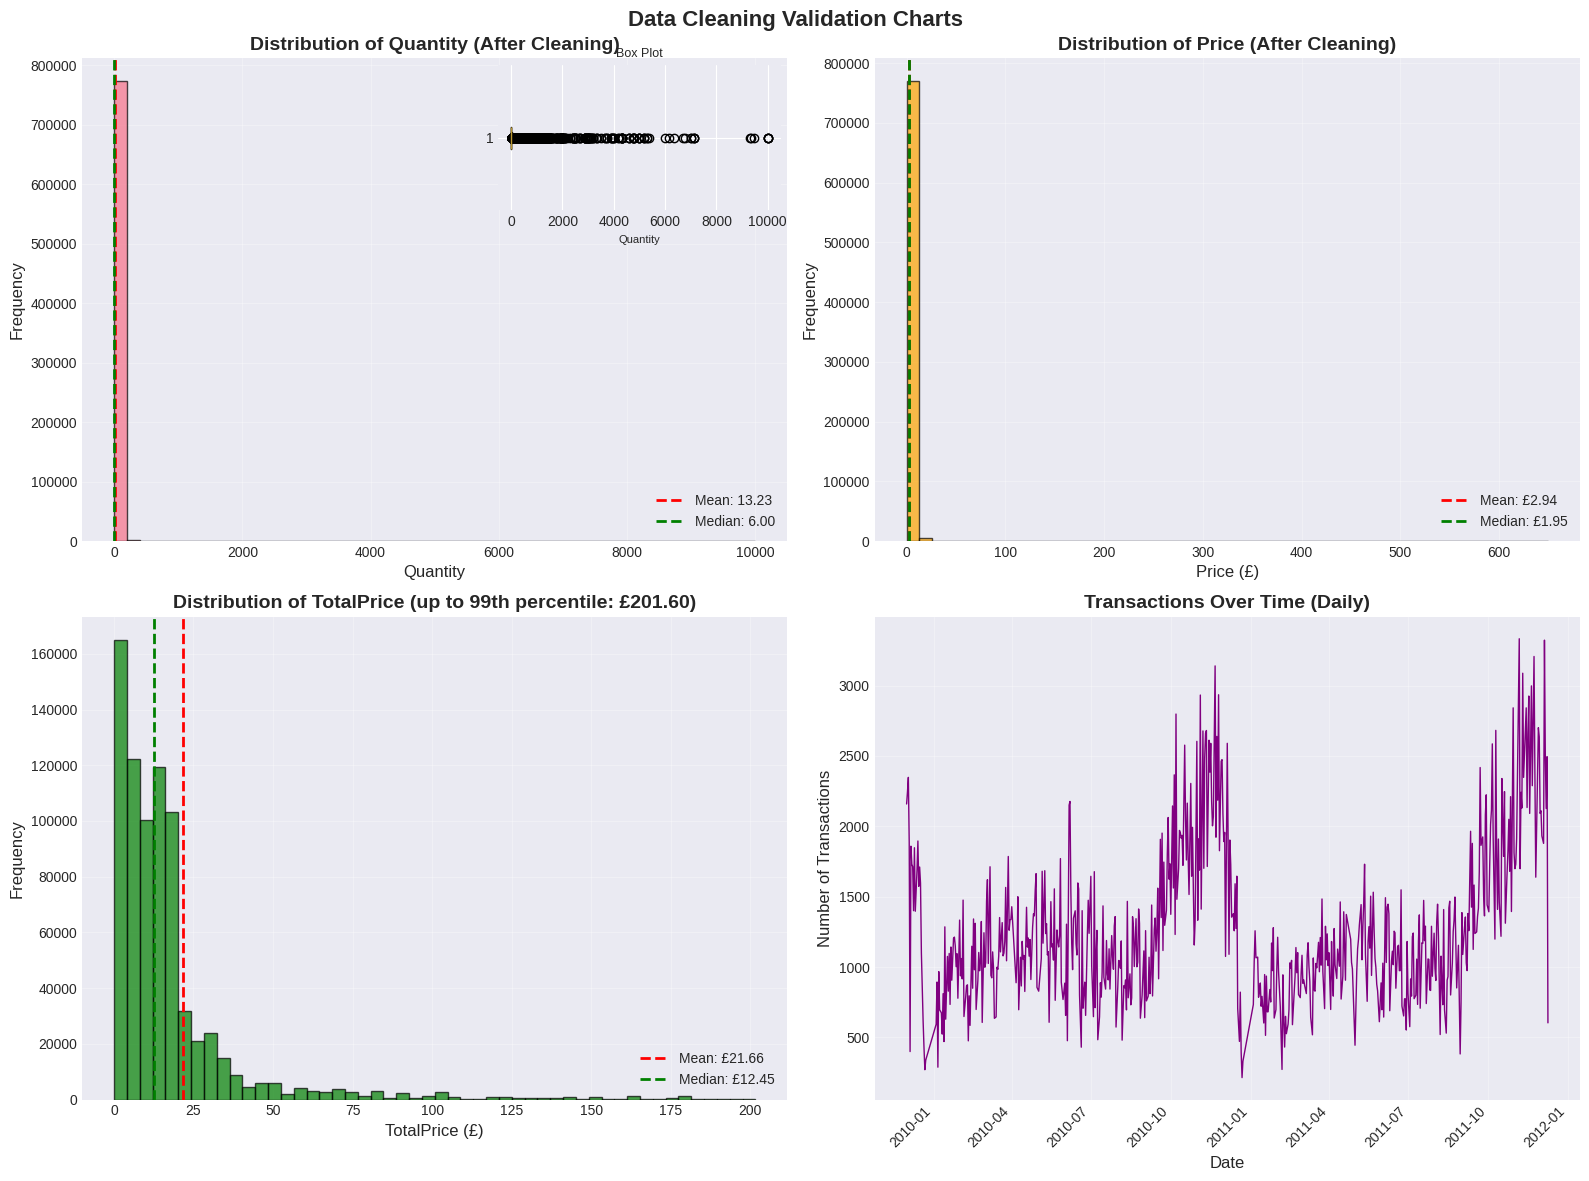

In [57]:
# validating if the extreme outliers are deleted, negative values exist and if the distrobution is normal and logical
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16,12))
fig.suptitle('Data Cleaning Validation Charts', fontsize=16, fontweight='bold')

# 1) Quantity distrobution chart
ax1 = axes[0, 0]
ax1.hist(df_clean['Quantity'], bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Quantity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Quantity (After Cleaning)', fontsize=14, fontweight='bold')
ax1.axvline(df_clean['Quantity'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_clean["Quantity"].mean():.2f}')
ax1.axvline(df_clean['Quantity'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_clean["Quantity"].median():.2f}')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# adding inset to box plot
axins1 = inset_axes(ax1, width="40%", height="30%", loc='upper right')
axins1.boxplot(df_clean['Quantity'], vert=False)
axins1.set_xlabel('Quantity', fontsize=8)
axins1.set_title('Box Plot', fontsize=9)


# Price distrobution chart
ax2 = axes[0, 1]
ax2.hist(df_clean['Price'], bins=50, edgecolor='black', alpha=0.7, color='orange')
ax2.set_xlabel('Price (£)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Price (After Cleaning)', fontsize=14, fontweight='bold')
ax2.axvline(df_clean['Price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: £{df_clean["Price"].mean():.2f}')
ax2.axvline(df_clean['Price'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: £{df_clean["Price"].median():.2f}')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# TotalPrice distrobution chart
ax3 = axes[1, 0]
total_price_99 = df_clean['TotalPrice'].quantile(0.99)
df_plot = df_clean[df_clean['TotalPrice'] <= total_price_99]
ax3.hist(df_plot['TotalPrice'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('TotalPrice (£)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title(f'Distribution of TotalPrice (up to 99th percentile: £{total_price_99:.2f})', fontsize=14, fontweight='bold')
ax3.axvline(df_clean['TotalPrice'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: £{df_clean["TotalPrice"].mean():.2f}')
ax3.axvline(df_clean['TotalPrice'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: £{df_clean["TotalPrice"].median():.2f}')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# number of transactions in time chart
ax4 = axes[1, 1]
daily_transactions = df_clean.groupby(df_clean['InvoiceDate'].dt.date).size()
ax4.plot(daily_transactions.index, daily_transactions.values, linewidth=1, color='purple')
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Number of Transactions', fontsize=12)
ax4.set_title('Transactions Over Time (Daily)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# rotating the x axes
for label in ax4.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')

plt.tight_layout()

# saving the charts
chart_filename = 'data_cleaning_validation.png'
plt.savefig(chart_filename, dpi=300, bbox_inches='tight')

### step16: final validation test

In [58]:
# Final validation Tests

# list of tests
tests_passed = []
tests_failed = []

# TEST: no nulls in customer id
test_1 = 'no NULLs in customer id'
try:
    assert df_clean['Customer ID'].isna().sum() == 0, "customer id contains nulls!"
    tests_passed.append(test_1)
    print(f"✓ PASS: {test_1}")
except AssertionError as e:
    tests_failed.append((test_1, str(e)))
    print(f"✗ FAIL: {test_1} - {e}")


# TEST: no negatives in quantity
test_2 = 'no negative quantity'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_2)
    print(f"✓ PASS: {test_2}")
except AssertionError as e:
    tests_failed.append((test_2, str(e)))
    print(f"✗ FAIL: {test_2} - {e}")

# TEST: no negatives or zero prices
test_3 = 'no negative or zero prices'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_3)
    print(f"✓ PASS: {test_3}")
except AssertionError as e:
    tests_failed.append((test_3, str(e)))
    print(f"✗ FAIL: {test_3} - {e}")

# TEST: TotalPrice calculated correctly
test_4 = 'correct total price'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_4)
    print(f"✓ PASS: {test_4}")
except AssertionError as e:
    tests_failed.append((test_4, str(e)))
    print(f"✗ FAIL: {test_4} - {e}")

# TEST: no complete duplicates
test_5 = 'no complete duplicates'
try:
    assert (df_clean['Quantity'] < 0).sum() == 0, "negative quantity found!"
    tests_passed.append(test_5)
    print(f"✓ PASS: {test_5}")
except AssertionError as e:
    tests_failed.append((test_5, str(e)))
    print(f"✗ FAIL: {test_5} - {e}")

# TEST: quantity in accepted range
test_6 = 'quantity in accepted range'
try:
    assert df_clean['Quantity'].min() >= 1, f"minimum quantity is {df_clean['Quantity'].min()}"
    assert df_clean['Quantity'].max() <= 10000, f"maximum quantity is {df_clean['Quantity'].max()}"
    tests_passed.append(test_6)
    print(f"✓ PASS: {test_6}")
except AssertionError as e:
    tests_failed.append((test_6, str(e)))
    print(f"✗ FAIL: {test_6} - {e}")

# TEST: invoice in accepted range
test_7 = 'invoice in accepted range'
try:
    min_date = df_clean['InvoiceDate'].min()
    max_date = df_clean['InvoiceDate'].max()
    assert min_date >= pd.Timestamp('2009-01-01'), f"Earliest date {min_date} is before 2009"
    assert max_date <= pd.Timestamp('2012-01-01'), f"Latest date {max_date} is after 2011"
    tests_passed.append(test_7)
    print(f"✓ PASS: {test_7}")
except AssertionError as e:
    tests_failed.append((test_7, str(e)))
    print(f"✗ FAIL: {test_7} - {e}")

✓ PASS: no NULLs in customer id
✓ PASS: no negative quantity
✓ PASS: no negative or zero prices
✓ PASS: correct total price
✓ PASS: no complete duplicates
✓ PASS: quantity in accepted range
✓ PASS: invoice in accepted range


In [59]:
# overall tests review
if tests_failed:
    print(f"Number of Failed Tests: {len(tests_failed)}")
    print(f"\nFailed Tests:")
    for test, error in tests_failed:
        print(f"test: {test}, error: {error}")
else:
    print("ALL TESTS PASSED")

ALL TESTS PASSED


## **EDA Phase**


### step1: preparing the data for EDA analysis

In [60]:
# setting plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# loading the Dataset
try:
  df = pd.read_pickle('online_retail_cleaned.pkl')
except FileNotFoundError:
  df = pd.read_csv('online_retail_cleaned.csv', parse_dates=['InvoiceDate'])

# checking data quality
print(f"number of records: {len(df)}")
null_counts = df.isnull().sum()
nan_counts = df.isna().sum()
if null_counts.sum() == 0:
  print("no null values found")
else:
  print(f"number of nulls found: {null_counts[null_counts > 0]}!!!")
if nan_counts.sum() == 0:
  print("no NAN values found")
else:
  print(f"number of NANs found: {nan_counts[nan_counts > 0]}!!!")

number of records: 776617
no null values found
no NAN values found


In [61]:
# overall stats for numeric columns
print(df[['Quantity', 'Price', 'TotalPrice']].describe())

       Quantity     Price  TotalPrice
count 776617.00 776617.00   776617.00
mean      13.23      2.94       21.66
std       67.06      4.42       82.63
min        1.00      0.03        0.06
25%        2.00      1.25        4.95
50%        6.00      1.95       12.45
75%       12.00      3.75       19.80
max    10000.00    649.50    38970.00


### step2: calculating invoice-level metrics

In [62]:
# grouping all records with the same order invoice number
invoice_metrics = df.groupby('Invoice').agg({
    'TotalPrice': 'sum',   # sum of all prices
    'Quantity': 'sum',     # sum of all quantities
    'StockCode': 'nunique', # unique stock codes
    'Customer ID': 'first', # first value (for repeated cols)
    'Country': 'first',     # first value (for repeated cols)
    'InvoiceDate': 'first' # first value (for repeated cols)
}).reset_index()

# changing invoice column names
invoice_metrics.columns = ['Invoice', 'OrderValue', 'OrderQuantity', 'UniqueProducts', 'Customer ID', 'Country', 'OrderDate']

invoice_metrics.head(10)

,Invoice,OrderValue,OrderQuantity,UniqueProducts,Customer ID,Country,OrderDate
0,489434,505.30,166,8,13085,United Kingdom,2009-12-01 07:45:00
1,489435,145.80,60,4,13085,United Kingdom,2009-12-01 07:46:00
2,489436,630.33,193,19,13078,United Kingdom,2009-12-01 09:06:00
3,489437,310.75,145,23,15362,United Kingdom,2009-12-01 09:08:00
4,489438,2286.24,826,17,18102,United Kingdom,2009-12-01 09:24:00
5,489439,372.30,216,18,12682,France,2009-12-01 09:28:00
6,489440,50.40,16,2,18087,United Kingdom,2009-12-01 09:43:00
7,489441,344.34,102,4,18087,United Kingdom,2009-12-01 09:44:00
8,489442,382.37,275,23,13635,United Kingdom,2009-12-01 09:46:00
9,489443,285.06,120,7,14110,United Kingdom,2009-12-01 09:50:00


### step3: calculating customer-level metrics

In [63]:
# grouping all records with the same customer id from invoice_metrics
customer_metrics = invoice_metrics.groupby('Customer ID').agg({
    'Invoice': 'count',
    'OrderValue': 'sum',
    'OrderDate': ['min', 'max'],
    'Country': 'first'
}).reset_index()

# changing multi-level column names
customer_metrics.columns = ['Customer ID', 'TotalOrders', 'TotalSpent', 'FirstPurchase', 'LastPurchase', 'Country']

customer_metrics.head(10)

,Customer ID,TotalOrders,TotalSpent,FirstPurchase,LastPurchase,Country
0,12346,11,372.86,2009-12-14 08:34:00,2010-06-28 13:53:00,United Kingdom
1,12347,8,4921.53,2010-10-31 14:20:00,2011-12-07 15:52:00,Iceland
2,12348,5,1658.40,2010-09-27 14:59:00,2011-09-25 13:13:00,Finland
3,12349,3,3678.69,2010-04-29 13:20:00,2011-11-21 09:51:00,Italy
4,12350,1,294.40,2011-02-02 16:01:00,2011-02-02 16:01:00,Norway
5,12351,1,300.93,2010-11-29 15:23:00,2010-11-29 15:23:00,Unspecified
6,12352,9,1729.54,2010-11-12 10:20:00,2011-11-03 14:37:00,Norway
7,12353,2,406.76,2010-10-27 12:44:00,2011-05-19 17:47:00,Bahrain
8,12354,1,1079.40,2011-04-21 13:11:00,2011-04-21 13:11:00,Spain
9,12355,2,947.61,2010-05-21 11:59:00,2011-05-09 13:49:00,Bahrain


In [64]:
# saving metrics
invoice_metrics.to_pickle('invoice_metrics.pkl')
customer_metrics.to_pickle('customer_metrics.pkl')
invoice_metrics.to_csv('invoice_metrics.csv')
customer_metrics.to_csv('customer_metrics.csv')

## analysis on statistical distrobutions

In [65]:
from scipy import stats

In [82]:
stats_summary = pd.DataFrame({
    'Quantity': [
        df['Quantity'].mean(),
        df['Quantity'].median(),
        df['Quantity'].std(),
        df['Quantity'].skew(),
        df['Quantity'].kurtosis()
    ],
    'Price': [
        df['Price'].mean(),
        df['Price'].median(),
        df['Price'].std(),
        df['Price'].skew(),
        df['Price'].kurtosis()
    ],
    'TotalPrice': [
        df['TotalPrice'].mean(),
        df['TotalPrice'].median(),
        df['TotalPrice'].std(),
        df['TotalPrice'].skew(),
        df['TotalPrice'].kurtosis()
    ]
}, index=['Mean', 'Median', 'Std', 'Skewness', 'Kurtosis'])

print(stats_summary)

          Quantity  Price  TotalPrice
Mean          9.78   2.89       15.77
Median        5.00   1.95       11.80
Std          19.55   3.21       17.71
Skewness     19.99   7.61        2.95
Kurtosis   1088.14 183.77       11.05


In [69]:
# identifying outliers with IQR method
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)]
print(outliers['Quantity'].head(10))

3     48
54    28
55    30
56    30
57    30
58    60
59    32
60    32
61    56
62    56
Name: Quantity, dtype: int64


### normal charts

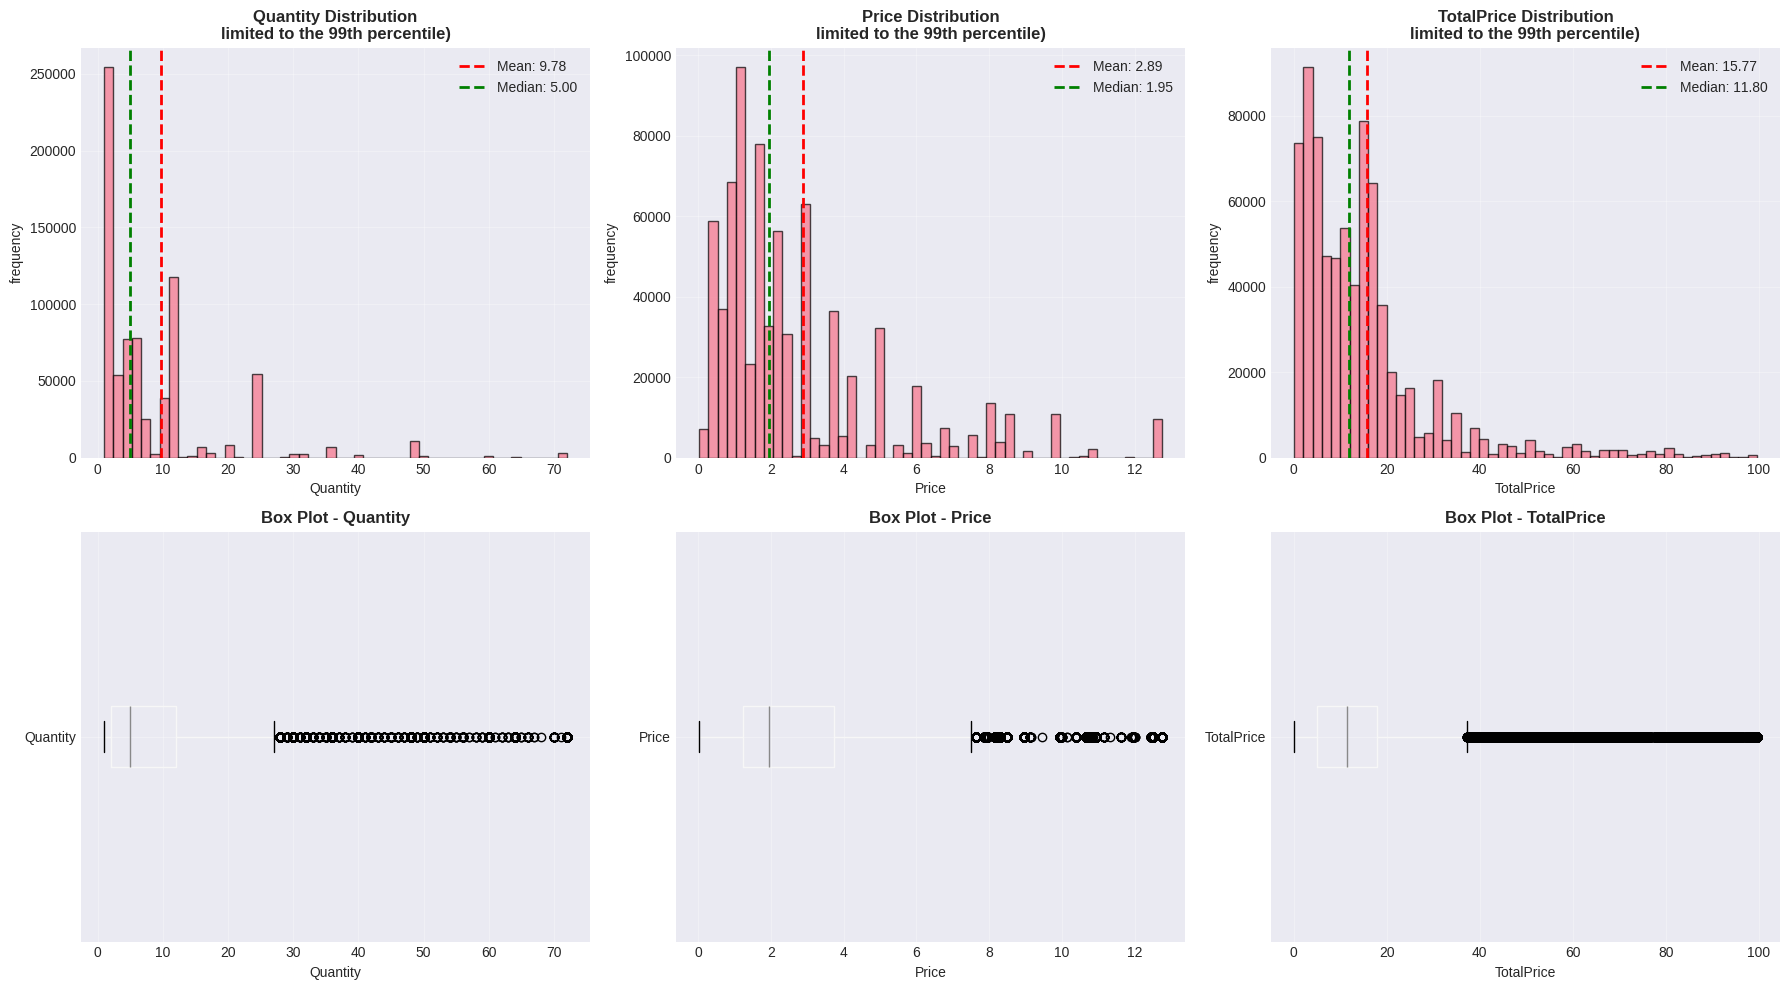

In [85]:
# generating the charts
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 10))

variables = ['Quantity', 'Price', 'TotalPrice']
titles = ['Quantity Distribution', 'Price Distribution', 'TotalPrice Distribution']

for idx, (var, title) in enumerate(zip(variables, titles), 1):
    # Histogram
    ax1 = plt.subplot(2, 3, idx)

    # limiting the x axis to the 99th percentile
    var_99 = df[var].quantile(0.99)
    df_plot = df[df[var] <= var_99]

    df_plot[var].hist(bins=50, edgecolor='black', alpha=0.7, ax=ax1)
    ax1.axvline(df[var].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[var].mean():.2f}')
    ax1.axvline(df[var].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[var].median():.2f}')
    ax1.set_title(f'{title}\nlimited to the 99th percentile)', fontsize=12, weight='bold')
    ax1.set_xlabel(var)
    ax1.set_ylabel('frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Box Plot
    ax2 = plt.subplot(2, 3, idx + 3)
    df_plot.boxplot(column=var, ax=ax2, vert=False)
    ax2.set_title(f'Box Plot - {var}', fontsize=12, weight='bold')
    ax2.set_xlabel(var)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [94]:
plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

### Transactions timeseries chart

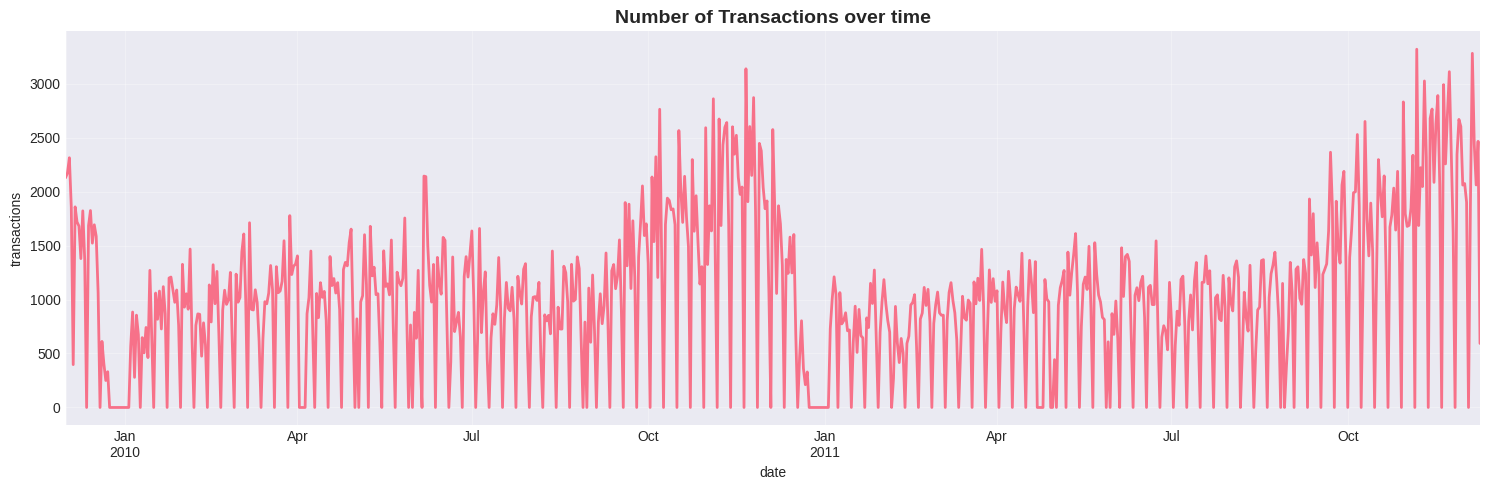

In [95]:
plt.figure(figsize=(15, 5))
df.set_index('InvoiceDate').resample('D')['Invoice'].count().plot(linewidth=2)
plt.title('Number of Transactions over time', fontsize=14, weight='bold')
plt.xlabel('date')
plt.ylabel('transactions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('eda_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

## RFM Analysis

### step1: setting a reference date

In [96]:
# taking 1 day after the last timestamp date on the dataset for measuring customer recency score
# calculating +1 day after the last date would make all of the recency dates positive!
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"date of the last transaction: {df['InvoiceDate'].max()}")
print(f"reference date: {reference_date}")

date of the last transaction: 2011-12-09 12:50:00
reference date: 2011-12-10 12:50:00


### step2: calculating the RFM score for each customer

In [97]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # recency
    'Invoice': 'nunique',                                     # frequency
    'TotalPrice': 'sum'                                       # monetary
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346,529,11,372.86
1,12347,2,8,4671.93
2,12348,75,5,1508.40
3,12349,19,3,3538.89
4,12350,310,1,294.40
5,12351,375,1,300.93
6,12352,36,9,1729.54
7,12353,204,2,406.76
8,12354,232,1,1079.40
9,12355,214,2,947.61


In [98]:
# cheking the stats of each metric for better understanding
rfm_stats = rfm[['Recency', 'Frequency', 'Monetary']].describe()
print(rfm_stats)

       Recency  Frequency  Monetary
count  5788.00    5788.00   5788.00
mean    201.48       6.08   2074.52
std     209.45      12.12   5677.53
min       1.00       1.00      2.90
25%      26.00       1.00    316.61
50%      96.00       3.00    790.10
75%     380.00       7.00   2011.94
max     739.00     373.00 241799.71


In [103]:
# calculating the RFM score by dividing each metric by 4 categories

# for recency the smaller the score the better!
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])

# for frequency and monetary the larger the score the better!
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4])

# combining for the Final score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'].head(6)

,RFM_Score
0,142
1,444
2,333
3,424
4,211
5,211


### step3: segmentation of customers

In [110]:
print(rfm['R_Score'].value_counts())
print(rfm['F_Score'].value_counts())
print(rfm['M_Score'].value_counts())

R_Score
4    1476
2    1441
1    1437
3    1434
Name: count, dtype: int64
F_Score
1    1447
2    1447
3    1447
4    1447
Name: count, dtype: int64
M_Score
1    1447
2    1447
3    1447
4    1447
Name: count, dtype: int64


In [112]:
# we will segment each customer according to their rfm score
# we will segmentate each customer by the best practice business scores for each value (r, f, m)
def rfm_segment(row):
  r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])

  if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
  elif r >= 3 and f >= 4:
        return 'Loyal Customers'
  elif r >= 4 and f >= 2 and f <=3:
        return 'Potential Loyalists'
  elif r <= 2 and f >= 3:
        return 'At Risk'
  elif r <= 2 and f <= 2:
        return 'Hibernating'
  elif r == 1:
        return 'Lost'
  else:
        return 'Other'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
rfm.head(10)

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346,529,11,372.86,1,4,2,142,At Risk
1,12347,2,8,4671.93,4,4,4,444,Champions
2,12348,75,5,1508.40,3,3,3,333,Other
3,12349,19,3,3538.89,4,2,4,424,Potential Loyalists
4,12350,310,1,294.40,2,1,1,211,Hibernating
5,12351,375,1,300.93,2,1,1,211,Hibernating
6,12352,36,9,1729.54,3,4,3,343,Loyal Customers
7,12353,204,2,406.76,2,2,2,222,Hibernating
8,12354,232,1,1079.40,2,1,3,213,Hibernating
9,12355,214,2,947.61,2,2,3,223,Hibernating


### step4: deeper analysis in each segment

In [126]:
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'Customer ID': 'count'
}).round(2)

print(segment_analysis.sort_values(by=('Monetary', 'mean'), ascending=False))

                    Recency        Frequency        Monetary          \
                       mean median      mean median     mean  median   
Segment                                                                
Champions             10.52   9.00     23.07  16.00  8831.27 5494.08   
Loyal Customers       44.02  40.00     11.45  10.00  3672.18 2753.01   
At Risk              280.37 248.00      6.39   5.00  1896.07 1232.79   
Potential Loyalists   13.42  14.00      3.70   3.00  1143.46  886.57   
Other                 52.91  52.00      2.75   2.00   933.47  647.68   
Hibernating          410.62 409.00      1.48   1.00   424.04  301.26   

                    Customer ID  
                          count  
Segment                          
Champions                   652  
Loyal Customers             555  
At Risk                     863  
Potential Loyalists         623  
Other                      1080  
Hibernating                2015  


In [127]:
# saving the results for later use
rfm.to_pickle('rfm_analysis.pkl')
rfm.to_csv('rfm_analysis.csv', index=False)

### step5: RFM customer segmentations charts

In [129]:
# getting a copy
rfm_viz = rfm.copy()

In [ ]:
# sankey chart

# calculating the number of customers for each route
sankey_data = rfm_viz.groupby(['R_Score', 'F_Score', 'M_Score', 'Segment']).size().reset_index(name='count')

# making unique labels for each of the nodes
labels = []
label_dict = {}
index = 0

# Recency nodes
for r in sorted(rfm_viz['R_Score'].unique()):
    label = f'R={r}'
    labels.append(label)
    label_dict[('R', r)] = index
    index += 1

# Frequency nodes
for f in sorted(rfm_viz['F_Score'].unique()):
    label = f'F={f}'
    labels.append(label)
    label_dict[('F', f)] = index
    index += 1

  # Monetary nodes
for m in sorted(rfm_viz['M_Score'].unique()):
    label = f'M={m}'
    labels.append(label)
    label_dict[('M', m)] = index
    index += 1

# Segment nodes
for seg in sorted(rfm_viz['Segment'].unique()):
    labels.append(seg)
    label_dict[('S', seg)] = index
    index += 1

# making Links
sources = []
targets = []
values = []

# R → F
rf_flow = rfm_viz.groupby(['R_Score', 'F_Score']).size().reset_index(name='count')
for _, row in rf_flow.iterrows():
    sources.append(label_dict[('R', row['R_Score'])])
    targets.append(label_dict[('F', row['F_Score'])])
    values.append(row['count'])

# F → M
fm_flow = rfm_viz.groupby(['F_Score', 'M_Score']).size().reset_index(name='count')
for _, row in fm_flow.iterrows():
    sources.append(label_dict[('F', row['F_Score'])])
    targets.append(label_dict[('M', row['M_Score'])])
    values.append(row['count'])

# M → Segment
ms_flow = rfm_viz.groupby(['M_Score', 'Segment']).size().reset_index(name='count')
for _, row in ms_flow.iterrows():
    sources.append(label_dict[('M', row['M_Score'])])
    targets.append(label_dict[('S', row['Segment'])])
    values.append(row['count'])

# ploting the sankey
fig_sankey = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
        color=['#FF6B6B', '#FFA07A', '#FFD93D', '#6BCF7F'] * 10  # رنگ‌های متنوع
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color='rgba(0,0,0,0.2)'
    )
)])

fig_sankey.update_layout(
    title={
        'text': 'customer flow Recency → Frequency → Monetary → Segment',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16, 'family': 'Arial'}
    },
    font=dict(size=12, family='Arial'),
    height=800,
    margin=dict(l=20, r=20, t=60, b=20)
)

In [141]:
# saving
fig_sankey.write_html('eda_sankey_chart.html')

In [144]:
# RFM grid heatmap (recency vs frequency)

# Grid 1: Recency (Y) vs Frequency (X) - color=number of customers
rf_grid = rfm_viz.groupby(['R_Score', 'F_Score']).size().unstack(fill_value=0)

# Grid 2: Recency (Y) vs Frequency (X) - color = monetary mean
rm_grid = rfm_viz.groupby(['R_Score', 'F_Score'])['Monetary'].mean().unstack(fill_value=0)

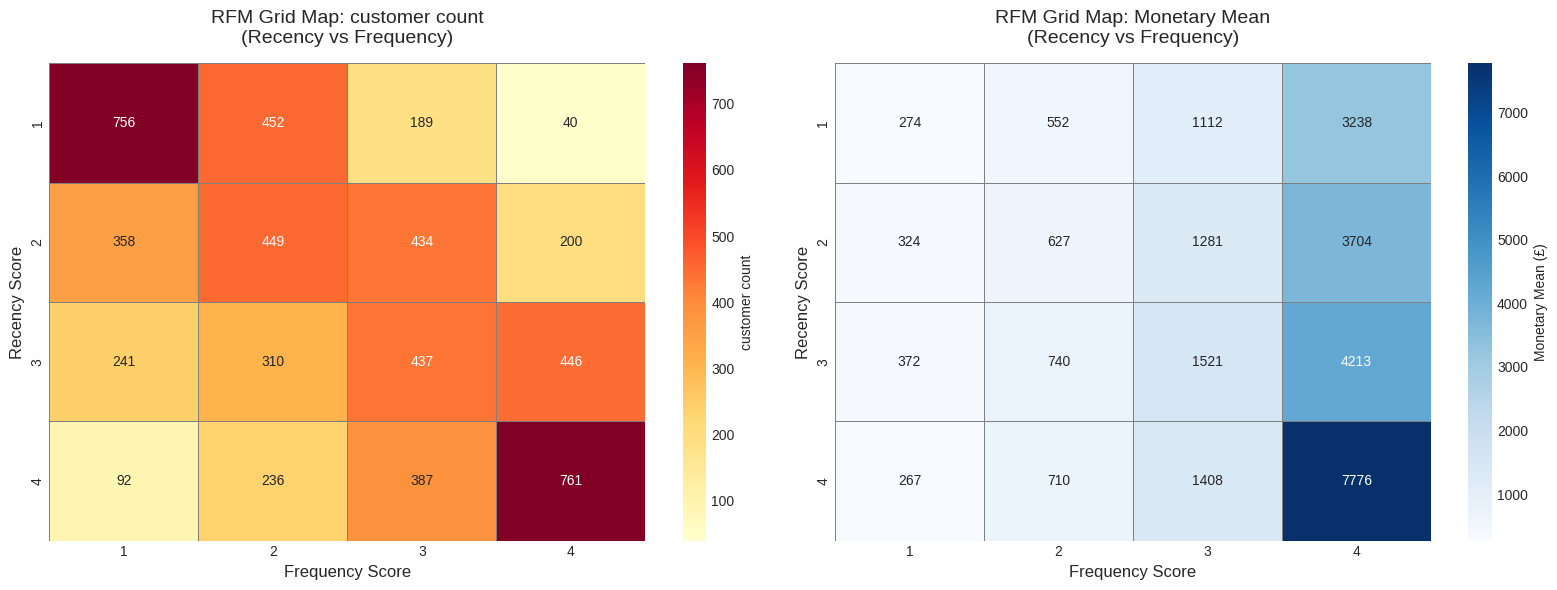

In [146]:
# ploting 2 heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# number of customers heatmap
sns.heatmap(rf_grid, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'customer count'},
            linewidths=0.5, linecolor='gray',
            ax=axes[0])
axes[0].set_title('RFM Grid Map: customer count\n(Recency vs Frequency)',
                  fontsize=14, pad=15)
axes[0].set_xlabel('Frequency Score', fontsize=12)
axes[0].set_ylabel('Recency Score', fontsize=12)
axes[0].invert_yaxis()  # R=4 on top

# monetary mean heatmap
sns.heatmap(rm_grid, annot=True, fmt='.0f', cmap='Blues',
            cbar_kws={'label': 'Monetary Mean (£)'},
            linewidths=0.5, linecolor='gray',
            ax=axes[1])
axes[1].set_title('RFM Grid Map: Monetary Mean\n(Recency vs Frequency)',
                  fontsize=14, pad=15)
axes[1].set_xlabel('Frequency Score', fontsize=12)
axes[1].set_ylabel('Recency Score', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('eda_rfm_grid_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

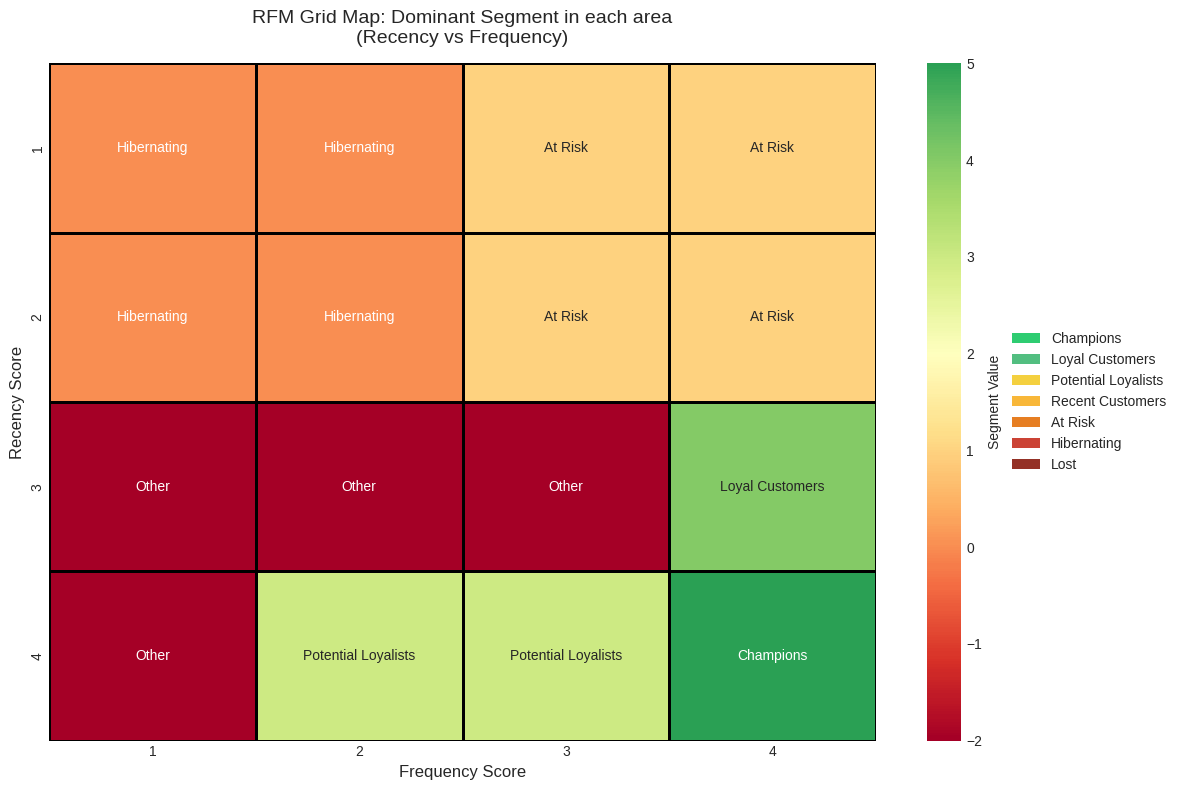

In [150]:
# combined RFM grid with segments
def get_dominant_segment(group):
    return group['Segment'].mode()[0] if len(group) > 0 else 'Unknown'

segment_grid = rfm_viz.groupby(['R_Score', 'F_Score']).apply(get_dominant_segment).unstack(fill_value='')

segment_colors = {
    'Champions': 5,
    'Loyal Customers': 4,
    'Potential Loyalists': 3,
    'Recent Customers': 2,
    'At Risk': 1,
    'Hibernating': 0,
    'Lost': -1,
    '': -2  # empty cells
}

segment_grid_numeric = segment_grid.applymap(lambda x: segment_colors.get(x, -2))

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(segment_grid_numeric, annot=segment_grid.values, fmt='',
            cmap='RdYlGn', center=2,
            cbar_kws={'label': 'Segment Value'},
            linewidths=1, linecolor='black',
            ax=ax)

ax.set_title('RFM Grid Map: Dominant Segment in each area\n(Recency vs Frequency)',
             fontsize=14, pad=15)
ax.set_xlabel('Frequency Score', fontsize=12)
ax.set_ylabel('Recency Score', fontsize=12)
ax.invert_yaxis()

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ECC71', label='Champions'),
    Patch(facecolor='#52BE80', label='Loyal Customers'),
    Patch(facecolor='#F4D03F', label='Potential Loyalists'),
    Patch(facecolor='#F8B739', label='Recent Customers'),
    Patch(facecolor='#E67E22', label='At Risk'),
    Patch(facecolor='#CB4335', label='Hibernating'),
    Patch(facecolor='#943126', label='Lost')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.savefig('eda_rfm_segment_grid.png', dpi=300, bbox_inches='tight')
plt.show()

In [156]:
# spider chart
segment_profiles = rfm_viz.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'  # تعداد مشتریان
}).reset_index()

segment_profiles['TotalRevenue'] = rfm_viz.groupby('Segment')['Monetary'].sum().values

segment_profiles.columns = ['Segment', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count', 'Total_Revenue']

# normalizing data in 0 to 1 range for fare segmentations
scaler = MinMaxScaler()
metrics_to_normalize = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count', 'Total_Revenue']

segment_profiles['Avg_Recency'] = segment_profiles['Avg_Recency'].max() - segment_profiles['Avg_Recency']

# normalizing
segment_profiles[metrics_to_normalize] = scaler.fit_transform(
    segment_profiles[metrics_to_normalize]
)

segment_profiles

,Segment,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Count,Total_Revenue
0,At Risk,0.33,0.23,0.18,0.21,0.18
1,Champions,1.00,1.00,1.00,0.07,1.00
2,Hibernating,0.00,0.00,0.00,1.00,0.03
3,Loyal Customers,0.92,0.46,0.39,0.00,0.26
4,Other,0.89,0.06,0.06,0.36,0.06
5,Potential Loyalists,0.99,0.10,0.09,0.05,0.00


In [158]:
# making the chart with plotly
categories = ['Avg Recency\n(Normalized)', 'Avg Frequency', 'Avg Monetary',
              'Customer Count', 'Total Revenue']
fig_spider = go.Figure()
colors = ['#2ECC71', '#52BE80', '#F4D03F', '#F8B739',
          '#E67E22', '#CB4335', '#943126']
for idx, row in segment_profiles.iterrows():
    values = row[metrics_to_normalize].tolist()
    values.append(values[0])  # بستن شکل چندضلعی

    fig_spider.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + [categories[0]],  # بستن شکل
        fill='toself',
        name=row['Segment'],
        line=dict(color=colors[idx % len(colors)], width=2),
        opacity=0.6
    ))

fig_spider.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickfont=dict(size=10)
        ),
        angularaxis=dict(
            tickfont=dict(size=11)
        )
    ),
    title={
        'text': 'مقایسه چندبعدی Segments (Spider Chart)<br><sub>همه متریک‌ها نرمال‌سازی شده [0-1]</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 16}
    },
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="middle",
        y=0.5,
        xanchor="left",
        x=1.05,
        font=dict(size=10)
    ),
    height=700,
    width=900
)

In [160]:
# saving
fig_spider.write_html('eda_spider_chart.html')

## Product Analysis

### step1: calculating product metrics

In [162]:
# calculating product metrics
product_metrics = df.groupby(['StockCode', 'Description']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'Price': 'mean',
    'Invoice': 'nunique',
    'Customer ID': 'nunique'
}).reset_index()